# Lie Groups and Learning Rotations
`Drew Wilimitis`

![title](images/q4.gif)

**Note:** I occasionally use the `geomstats` library for visualization (https://github.com/geomstats/geomstats)

The group theoretic approach to machine learning used here is somewhat of an extension of the more traditional methods of Manifold Learning. Riemannian, and often non-Euclidean, geometries provide the background setting in which Lie Groups can be incorporated to learn from sets of training images and predict rotational trajectories. <br>

There are a few Python libraries that have implemented classes of Lie Groups, such as `geomstats`, `theano`, and `PyGeometry`, however; I will attempt to implement the algorithm outlined primarily in **[3]**

## Mathematical Background

**Definition**: A **group** $G = (X, *)$ is just a set endowed with the operation $*$ that satisfies a few basic axioms <br>

1. For any $x, y \in G, x y$ is also an element of $G$ (closure).
2. For any $x, y, z \in G, \quad(x y) z=x(y z)$ (associativity).
3. There is a unique element of $G,$ denoted $e,$ and called the identity element, for which
$$
e x=x e=x \text { for any } x \in G
$$
4. For any $x \in G$ there is a corresponding element $x^{-1} \in G,$ called the inverse of $x,$ which
$$
\text { satisfies } x x^{-1}=x^{-1} x=e
$$

**Definition**: A **Lie group** $G$ is a **topological group** that is also a differentiable manifold. As opposed to discrete groups, a Lie group is therefore continuous and can be considered to represent continuous symmetries such as rotating a unit circle in a Euclidean plane or the group of rotations in $\mathbb{R^3}$<br>

There are a few classic examples of Lie groups sometimes called *matrix groups*, and the one we focus on is called the **Special Orthogonal Group** - $\mathrm{SO}(\mathrm{n})$

The special orthogonal group is the set of $N x N$ orthogonal matrices, denoted $\mathrm{SO}(\mathrm{n})$, which is the Lie group of rotation matrices in $\mathbb{R^n}$ with unit determinant. <br>

$$
S O(n)=\left\{R \in \mathbb{R}_{n \times n}: R^{T} . R=I d_{n} \text { and } \operatorname{det} R=1\right\}
$$ 

For $\mathrm{SO}(\mathrm{3})$, rotation matrices are in $\mathbb{R^{3 x 3}}$, and the Lie group is of dimension $n(n-1) / 2$

We can imagine the standard basis for this group of rotation matrices is given by the following rotation matrices:

$$
L_{\mathbf{x}}=\left[\begin{array}{ccc}
{0} & {0} & {0} \\
{0} & {0} & {-1} \\
{0} & {1} & {0}
\end{array}\right], \quad L_{\mathbf{y}}=\left[\begin{array}{ccc}
{0} & {0} & {1} \\
{0} & {0} & {0} \\
{-1} & {0} & {0}
\end{array}\right], \quad L_{\mathbf{z}}=\left[\begin{array}{ccc}
{0} & {-1} & {0} \\
{1} & {0} & {0} \\
{0} & {0} & {0}
\end{array}\right]
$$

### Import libraries and load data

In [183]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os
import geomstats

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

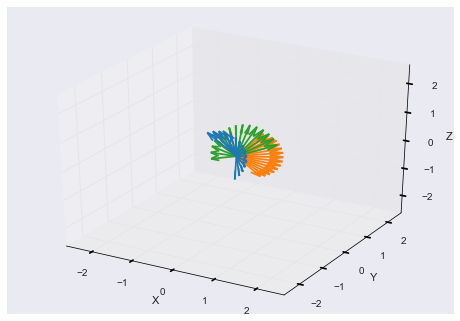

In [185]:
from geomstats.special_orthogonal_group import SpecialOrthogonalGroup
from geomstats.visualization import plot
SO3_GROUP = SpecialOrthogonalGroup(n=3)
METRIC = SO3_GROUP.left_canonical_metric

pts = SO3_GROUP.random_uniform(n_samples=2)
geodesic = METRIC.geodesic(initial_point=pts[0],end_point=pts[1])
n_steps = 15
t = np.linspace(-1, 1, n_steps)

points = geodesic(t)
visualization.plot(points, space='SO3_GROUP')
plt.show();

$$
\theta=\arccos \left(\frac{\operatorname{Tr}(R)-1}{2}\right)
$$

$$
\omega=\frac{1}{2 \sin \theta}\left[\begin{array}{c}
{R(3,2)-R(2,3)} \\
{R(1,3)-R(3,1)} \\
{R(2,1)-R(1,2)}
\end{array}\right]
$$

$$
\begin{array}{l}
{t=Q_{x x}+Q_{y y}+Q_{z z}} \\
{r=\sqrt{1+Q_{x x}-Q_{y y}-Q_{z z}}} \\
{s=\frac{1}{2 r}} \\
{w=\left(Q_{z y}-Q_{y z}\right) s} \\
{x=\frac{1}{2} r} \\
{y=\left(Q_{x y}+Q_{y x}\right) s} \\
{z=\left(Q_{z x}+Q_{x z}\right) s}
\end{array}
$$

In [186]:
class SO_GROUP():
    """ Special Orthogonal Group SO(N) """

    def __init__(self, N = 3):
        """
        Initialize instance, set hardcode rotation window for now
        Parameters
        ----------
        N : dimension of Euclidean rotational space, default to 3
        """
        self.N = N
        self.dim = int(N * (N-1) / 2)  # dimension of Lie group
        self.rotation_window = np.round(2*np.pi, 3) # maximum radius of rotation arc
        self.identity = np.eye(N) # set identity element of the group
        self.default_axis = np.array([0, 0, 1]) # used in axis-angle form with small rotation angles
        
    def normalize(v):
        """
        Divide a vector by given norm to standardize unit length for axis-angle format
        Parameters
        ----------
        v : axis-vector shape (N, 1)
        """
        if np.linalg.norm(v) > 1:
            return v / np.linalg.norm(v)
        else:
            return v
        
    def validate(G, format_type = 'matrix'):
        """
        Checks on rotation matrix elements contained within SO(N)
        Parameters
        ----------
        G : array, shape (n_samples, N, N)
        """
        # first check
        if G.shape[0] == 0:
            print('Given empty input')
            return False
        
        # convert to (n_samples, N, N)
        if format_type != 'matrix':
            G = self.axis_angle_to_matrix
            
        # check square N x N matrices
        if G.shape[1] != self.N or G.shape[2] != self.N:
            print('Given wrong input matrix dimensions: {} x {}'.format(G.shape[1], G.shape[2]))
            return False
        
        # check orthogonality condition (R * R^T = 1 or det(R) = 1)
        if (np.allclose(np.matmul(g, g.T), np.eye(self.N)) for g in G).all():
            return True
        
    def rotation_matrix_to_axis_angle(R):
        """
        Convert from (N, N) rotation matrix to axis-angle representation
        Parameters
        ----------
        R : array, shape (N, N)
        
        Returns
        ----------
        theta (angle) = arccos(Tr(R) - 1) / 2
        omega (normalized axis) = 1/(2*sin(theta)) [R(3,2)-R(2,3)} \\
                                                   {R(1,3)-R(3,1)} \\
                                                   {R(2,1)-R(1,2)}]
        """
        APPROX = True
        np.testing.assert_array_equal(R.shape, (self.N, self.N))
        theta = np.arccos((np.matrix.trace(R) - 1) / 2)
        if theta == 0:
            return (self.default_axis, theta)
        else:
            axis = np.zeros((3, 1))
            axis[0, 0] = R[2, 1] - R[1, 2]
            axis[1, 0] = R[0, 2] - R[2, 0]
            axis[2, 0] = R[1, 0] - R[0, 1]
            if APPROX:
                return (axis * np.sign(theta)) / np.linalg.norm(axis)
            else:
                omega = (1 / (2*np.sin(theta))) * axis * np.sign(theta)
                return (normalize(omega), theta % np.pi)
            
        def rotation_matrix_to_quaternion(R):
        """
        Convert from (N, N) rotation matrix to unit quaternion q = w + xi + yj + zk representation
        Parameters
        ----------
        R : array, shape (N, N)
        
        Returns
        ----------
        Q : 4x1 vector representing quaternion components 

        """
        eps = 1e-6
        max_index = np.argmax(R.diagonal())
        if max_index == 0:
            tr_Q = R[0, 0] - R[1, 1] - R[2, 2]
        elif max_index == 1:
            tr_Q = R[1, 1] - R[2, 2] - R[0, 0]
        else:
            tr_Q = R[2, 2] - R[0, 0] - R[1, 1]
        r = 1 + tr_Q
        if np.abs(r - 0) < eps:
            return quaternion_from_axis_angle(self.default_axis, 0)
        else:
            u = max_index
            v = (max_index + 1) % 3
            w = (max_index + 2) % 3
            s = 1 / (2 * r)
            q0 = R[w, v] - R[v, w] # w
            qu = r / 2 # x
            qv = (R[u, v] + R[v, u]) * s # y
            qw = (R[w, u] + R[u, w]) * s # z

            Q[0] = R[w, v] - R[v, w] # w
            Q[u + 1] = r / 2 
            Q[v + 1] = (R[u, v] + R[v, u]) * s
            Q[w + 1] = (R[w, u] + R[u, w]) * s # z
            if Q[0] < 0:
                Q = -Q
            
            
            
        

IndentationError: expected an indented block (<ipython-input-186-be4ab0e7eeee>, line 95)

In [160]:
SO3 = SO_GROUP(N=2)
SO3.dim

1

# References
___

**1.]** T. Liu, Z. Shi and Y. Liu, "Visualization of the Image Geometric Transformation Group Based on Riemannian Manifold," in IEEE Access, vol. 7, pp. 105531-105545, 2019. <br>
**2.]** D. Lin, E. Grimson, and J. Fisher, ‘‘Learning visual flows: A lie algebraic
approach,’’ in Proc. IEEE Conf. Comput. Vis. Pattern Recognit. (CVPR),
Jun. 2009, pp. 747–754<br>
**3.]** R. Arora. On learning rotations. In Y. Bengio, D. Schuurmans, J. Lafferty, C. K. I. Williams,
and A. Culotta, editors, Advances in Neural Information Processing Systems, volume 22, pages
55–63. MIT Press, 2009.